In [1]:
# Importing built-in libraries
import os
import glob

# Importing WFDB library for getting data
from wfdb.io import get_dbs
from wfdb.io import dl_database

In [2]:
# Change current working directory

print("Directory before changing it: " + os.getcwd())
os.chdir("..")
print("Directory after changing it: " + os.getcwd())

Directory before changing it: /home/ferhat/PycharmProjects/arrhythmia-cnn/notebooks
Directory after changing it: /home/ferhat/PycharmProjects/arrhythmia-cnn


In [3]:
# Downlaod data if it's not exist in data directory,
# otherwise download it from PhysioNet

if not os.path.exists("data/mitdb"):
    dbs = get_dbs()
    print(dbs)

    subs = 'MIT-BIH'
    res = [[index, sub_string] for index, sub_string in enumerate(dbs) if subs in sub_string[1]]
    print(res)
    os.mkdir("data/mitdb")
    dl_database('mitdb', dl_dir='data/mitdb')
else:
    print("Data directory exists")

Data directory exists


In [4]:
# Getting paths for records and annotations
record_paths = glob.glob("data/mitdb/*.dat")
annot_paths = glob.glob("data/mitdb/*.atr")
hea_paths = glob.glob("data/mitdb/*.hea")

# Sort lists
record_paths.sort()
annot_paths.sort()
hea_paths.sort()

# Throws error if total data file number is not equeal to other specs
try:
    if len(record_paths) != len(annot_paths) != len(hea_paths):
        raise IOError

except IOError:
    print("Some data files are missing!")

In [5]:
# Importing WFDB plot functions, uses Matplotlib
from wfdb.io import rdann, rdrecord
from wfdb.plot import plot_wfdb

# Read 2 channel record and it's annotation
record = rdrecord(record_paths[0].split(".")[0], sampto=3000)
ann = rdann(annot_paths[0].split(".")[0], "atr", sampto=3000)

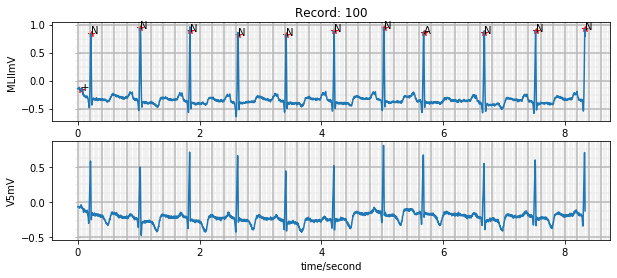

In [6]:
# Plot graph with grids
plot_wfdb(record=record, annotation=ann, plot_sym=True,
          time_units='seconds',
          figsize=(10, 4), ecg_grids='all')

In [7]:
# Import beat dictionary
from data import beat_ann

# Create empty dictionary to hold all count values
beat_count_dict = {}
# Take all patients in annotation lists
for patient in range(len(annot_paths)):
    ann = rdann(annot_paths[patient].split(".")[0], "atr")
    # Take all beats
    for beat_type in ann.symbol:
        # Check if beat type is in pre-defined beat dictionary
        if beat_type in beat_ann:
            # If dictionary does not include that beat type create a key-value pair and assign to 1
            if beat_type not in beat_count_dict.keys():
                beat_count_dict[beat_type] = 1
                # beat_list.append(list(beat_annots.keys()).index(beat_type))
            # Otherwise add 1 to value of matched beat type
            else:
                beat_count_dict[beat_type] += 1
                # beat_list.append(list(beat_annots.keys()).index(beat_type))

In [8]:
# Importing matplotlib library to plot bars of beat counts
import numpy as np
from data import sb_ann

sb_list = []

count_labels, count_values = np.array(list(beat_count_dict.items())).T

for beat_type in list(sb_ann.keys()):
    sb_list.append([beat_type,
                    count_values[list(count_labels).index(beat_type)],
                    sb_ann[beat_type]])

sb_list = np.array(sb_list)

In [9]:
# Importing Seaborn and Matplotlib.PyPlot to plot graphs
import seaborn as sns
import matplotlib.pyplot as plt
# Importing Matplotlib.Patches to create custom legends
import matplotlib.patches as mpatches

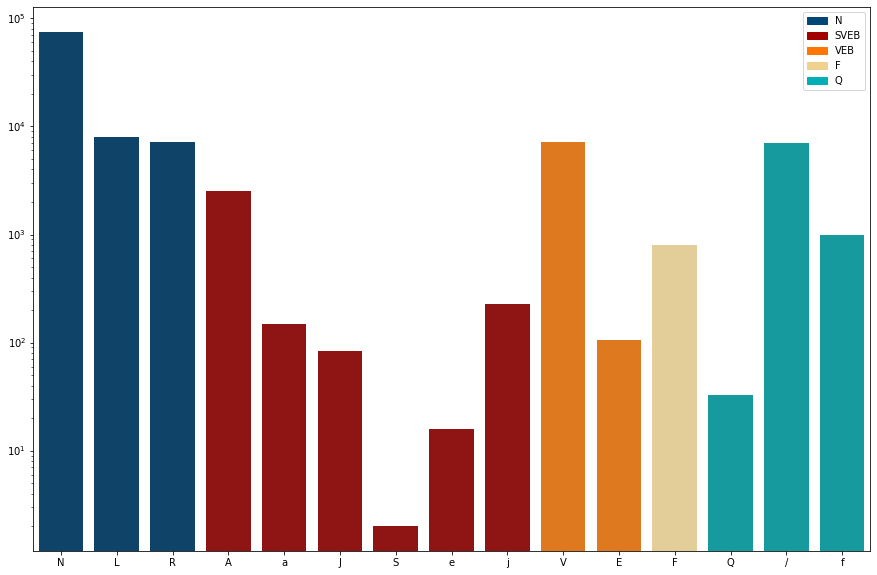

In [10]:
# Importing only super class names
from data import sb_ann_palette, sb_ann_class, sb_ann_class_palette

# Creating plot figure with specified size
plt.figure(figsize=(15, 10))
# Defining legend patches for superior arrythmia classes
patch_list = [mpatches.Patch(color=p, label=l) for p, l in zip(sb_ann_class_palette, sb_ann_class)]               

# Ploting bar plot with seaborn
ax = sns.barplot(sb_list[:, 0], sb_list[:, 1],
                 palette=sb_ann_palette)
# Setting y-axis to logarithmic scale
ax.set_yscale("log")
# Implementing custom legend
leg = ax.legend(handles=patch_list)